<a href="https://colab.research.google.com/github/AtsushiNi/myLeprecon/blob/master/niihama/analyze_1-4/analyze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 概要
データを撮り直した
スリット幅: 50μm
露光時間: 150s
プラズマ電流: 2.5A

基底準位が、ボルツマン分布に従うと仮定する
$$\frac{n_{XvN}}{(2N+1)g^N_{as}}=n_X\exp\left(-\frac{E^{Xv}_{rot}(N)}{k_BT^{Xv}_{rot}}\right)exp\left(-\frac{E^{X}_{vib}(v)}{k_BT^{X}_{vib}}\right)$$
上式の<br>
　$T^{Xv}_{rot}$: 上準位ボルツマンプロットおよび回転定数の比<br>
　$T^{Xv}_{vib}$: コロナモデルに代入した上で回転量子数で和を取りv<3で計算<br>
求めた二つの温度を代入して$n_{XvN}$を求める


### 変数名について
| | 振動量子数 | 回転量子数 |
| --- | :---: | :---: |
| 基底準位 | Xv | XN |
| 発光上準位 | dv | dN |
| 発光下準位 | av | aN |

| | 占有数分布 |
| -- | :--: |
| 基底準位 | nX |
| 上準位 | nd |

In [1]:
!pip install netCDF4

     |████████████████████████████████| 4.7MB 9.0MB/s 
     |████████████████████████████████| 296kB 46.6MB/s 


In [2]:
import os
from os.path import join
import math
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import math
from scipy.optimize import curve_fit
from sympy.physics.wigner import wigner_3j

In [3]:
data_path = '/content/drive/MyDrive/研究室/myLeprecon/niihama/analyze_1-4'
image_path = '/content/drive/MyDrive/研究室/images/analyze_1-4'
print(os.path.exists(data_path))

True


In [4]:
# 発光線データの読み込み
data_0 = xr.load_dataarray(join(data_path, 'array_0.nc'))
data_1 = xr.load_dataarray(join(data_path, 'array_1.nc'))
data_2 = xr.load_dataarray(join(data_path, 'array_2.nc'))
data_0

<xarray.DataArray (dN: 7)>
array([1296033.77015074,  395341.24266383,  573863.589096  ,
         82733.91566048,  104743.89910178,   13820.36172344,
        101330.32502494])
Coordinates:
  * dN          (dN) int64 1 2 3 4 5 6 7
    wavelength  (dN) float64 601.8 602.4 603.2 604.3 605.6 607.2 609.0
    intensity   (dN) float64 1.296e+06 3.953e+05 ... 1.382e+04 1.013e+05

# 定数

In [5]:
# プランク定数[ev/s]
planck_constant = 4.13567e-15
# 光速[m/s]
light_speed = 299792458
# ボルツマン定数
kb = 8.6171e-5 # [eV K^-1]

# 石原さん修論より
Be = [60.853, 30.364, 1.671] # X, d, a準位のBe
ae = [3.062, 1.545, 1.671] # X, d, a準位のαe
De = [0.0471, 0.0191, 0.0216] # X, d, a準位のDe
we = [4401.21, 2371.57, 2664.83] # X, d, a準位のwe
wx = [121.33, 66.27, 71.65] # X, d, a準位のwx
Te = 5 / kb # 電子温度[K] (5eV)

# Franck-Condin因子
franck_condon = np.loadtxt('/content/drive/MyDrive/研究室/myLeprecon/franck_condon_factor.txt')

# 核スピンの縮退度(核スピンの統計重率)
def g_as(dN):
  return (dN % 2) * 2 + 1

###### 回転定数
# 基底準位の回転定数
def B_X(Xv):
  return Be[0] - ae[0]*(Xv+0.5)
# 上準位の回転定数
def B_d(dv):
  return Be[1] - ae[1]*(dv+0.5)

###### 回転エネルギー
# 基底準位の回転エネルギー(eV)
def E_X_rot(Xv, XN):
  return (B_X(Xv)*XN*(XN+1) - De[0]*XN*(XN+1)*XN*(XN+1))*1.23984/1e4
# 上状態の回転エネルギー(eV)
def E_d_rot(dv, dN):
  return (B_d(dv)*dN*(dN+1)-De[1]*dN*(dN+1)*dN*(dN+1))*1.23984/1e4

###### 振動エネルギー
# 基底準位の振動エネルギー
def E_X_vib(v):
  return (we[0]*(v+0.5) - wx[0]*(v+0.5)*(v+0.5))*1.23984/1e4

# 上準位の振動エネルギー
def E_d_vib(v):
  return (we[1]*(v+0.5) - wx[1]*(v+0.5)*(v+0.5))*1.23984/1e4

###### R導出用の諸々
# 振動励起の電子衝突断面積(の多分相対値)
def ccs(vX, vd):
  return np.exp(-((E_d_vib(vd)-E_d_vib(0))-(E_X_vib(vX) - E_X_vib(0)))/ kb / Te)
# 電子速度で平均化した部分断面積　石原さんの修論より
Qr = np.array([0.76,0.122,0.1,0.014])
# 回転構造の分岐比
def branch_ratio(NX, Nd):
  rtp_value = 0
  for r in range(1, 5, 1):
    rtp_value += Qr[r-1]*(2*Nd+1)*(wigner_3j(Nd, r, NX, 1, -1, 0))**2
  return rtp_value
# 禁止遷移は励起係数は0
def kronecker_delta(NX, Nd):
  if(NX % 2 == Nd % 2):
    return 1
  else:
    return 0


### 自然発光係数 A
$$A^{dv'N'}_{av"N"} = A^{dv'}_{av"} \times S^{N'}_{N"}$$
$$S^{N'}_{N"} = \frac{2N'+1}{2}$$

In [6]:
A_array = [2.4077e7, 2.0655e7, 1.7377e7, 1.4317e7]
def A(dv, dN, av, aN):
  if (dv == av and dN == aN):
    return A_array[dv] * (2*dN+1) / 2
  else:
    return 0

## 電子衝突励起係数 R
$$R^{dv'N'}_{XvN}=q^{dv'}_{Xv}<\sigma^{FC}_{v'\leftarrow v}v_e>a^{1N'}_{0N}\delta^{g^{N'}_{as}}_{g^N_{as}}$$

In [7]:
def R(Xv, XN, dv, dN):
  dv = int(dv) # 少数が来ると整数にキャストしないとエラーになる
  return franck_condon[Xv][dv] * ccs(Xv, dv) * branch_ratio(XN, dN) * kronecker_delta(XN, dN)


# 新しいフィッティング方法
コロナモデル
$$
n_e\sum_{v, N}\left[n_{XvN}R^{dv'N'}_{XvN}\right]= n_{dv'N'}\sum_{v"N"}A^{dv'N'}_{av"N"}
$$

基底準位のボルツマン分布
$$
\frac{n_{XvN}}{(2N+1)g^N_{as}}=n_X\exp\left(-\frac{E^{Xv}_{rot}(N)}{k_BT^{Xv}_{rot}}\right)exp\left(-\frac{E^{X}_{vib}(v)}{k_BT^{X}_{vib}}\right)
$$
以上２式より
$$
\begin{align}
n_e \sum_{v,N} \left[ R^{dv'N'}_{XvN} (2N+1)g^N_{as} n_X \exp\left(-\frac{E^{Xv}_{rot}(N)}{k_BT^{Xv}_{rot}}\right)exp\left(-\frac{E^{X}_{vib}(v)}{k_BT^{X}_{vib}}\right) \right] &= \frac{n_{dv'N'}}{V}\sum_{v"N"}A^{dv'N'}_{av"N"} \\
&=\frac{I^{dv'N'}_{av"N"}\lambda^{dv'N'}_{av"N"}}{Vhc}\frac{1}{A^{dv'N'}_{av"N"}}\sum_{v"N"}A^{dv'N'}_{av"N"}
\end{align}
$$

両辺をv',N'の関数とみて、$T^{Xv}_{rot}$と$T^{X}_{vib}$をパラメータとしてフィッティング<br>
(フィッティングデータは全て$v'=v", N'=N"$なので、$\frac{1}{A^{dv'N'}_{av"N"}}\sum_{v"N"}A^{dv'N'}_{av"N"}=1$を満たす)<br>
Vはプラズマ体積

In [8]:
def right_formula(dvs, dNs):
  result = []
  for i, dv in enumerate(dvs):
    dN = dNs[i]
    if dv == 0:
      result.append(data_0.sel(dN=dN)['intensity'].values * data_0.sel(dN=dN)['wavelength'].values*1e-6 / planck_constant / light_speed / ((2 * math.pi) * (200 * math.pi * 1e-4)))
    elif dv == 1:
      result.append(data_1.sel(dN=dN)['intensity'].values * data_1.sel(dN=dN)['wavelength'].values*1e-6 / planck_constant / light_speed / ((2 * math.pi) * (200 * math.pi * 1e-4)))
    elif dv == 2:
      result.append(data_2.sel(dN=dN)['intensity'].values * data_2.sel(dN=dN)['wavelength'].values*1e-6 / planck_constant / light_speed / ((2 * math.pi) * (200 * math.pi * 1e-4)))
  return result


In [9]:
def left_formula(X, T_X_rot_0, T_X_rot_1, T_X_rot_2, T_X_vib, n_X):
  ne = 1.8e16
  dv, dN = X
  T_X_rot_list = [T_X_rot_0, T_X_rot_2, T_X_rot_2]
  dv = np.array(dv)
  dN = np.array(dN)
  result = np.zeros((len(dv)))
  for Xv in range(0, 3):
    for XN in range(1, 15):
      result = [r + R(Xv, XN, dv[i], dN[i]) * (2*XN+1) * g_as(XN) * math.exp(-E_X_rot(Xv, XN)/kb/T_X_rot_list[Xv]) * math.exp(-E_X_vib(Xv)/kb/T_X_vib) for i, r in enumerate(result)]
  return np.array([ float(ne* n_X * r) for r in result])


/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[4.34595179e+02 4.01000000e+02 3.92318798e+02 4.08852757e+03
 3.68669409e-07]


(0.5, 3.0)

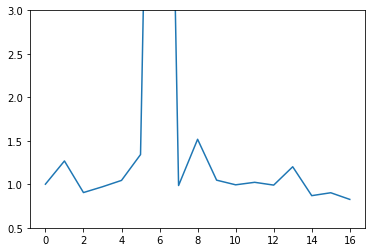

In [15]:
dvs = [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
dNs = [1, 2, 3, 4, 5, 6, 7, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5]
fitting_result, a = curve_fit(left_formula, (dvs, dNs), right_formula(dvs, dNs), p0=(359, 401, 366, 3958.8, 7.765e5))
print(fitting_result)
r = right_formula(dvs, dNs)
l = left_formula((dvs, dNs), *fitting_result)
plt.plot([rr/l[i] for i, rr in enumerate(r)])
plt.ylim(0.5, 3)
plt.ylabel("right / left")

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
No handles with labels found to put in legend.


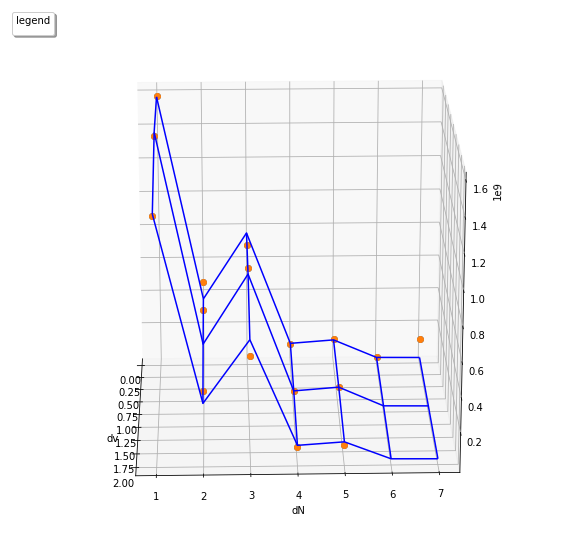

In [11]:
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
import  matplotlib.animation as animation

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
flag = False

def init():
  global flag
  dvs = [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
  dNs = [1, 2, 3, 4, 5, 6, 7, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5]
  ax.view_init(azim=0, elev=20)
  ax.set_xlabel('dv')
  ax.set_ylabel('dN')
  ax.plot(dvs, dNs, right_formula(dvs, dNs), marker='o', linestyle='None')

  if flag == True:
    x = np.arange(0, 3)
    y = np.arange(1, 8)
    X, Y = np.meshgrid(x, y)
    Z = np.array([ left_formula((xx, Y[i]), *fitting_result) for i, xx in enumerate(X)])
    ax.plot_wireframe(X, Y, Z, color='blue')
    ax.legend(loc=2, title='legend', shadow=True)
  flag = True
  return fig,

def animate(i):
  ax.view_init(azim=1.5*i, elev=20)
  return fig,

ani = animation.FuncAnimation(fig, animate, init_func=init, frames=int(360/1.5), interval=100, blit=True)
HTML(ani.to_html5_video())

# 基底準位の占有数分布
$$
n_{XvN}=n_X(2N+1)g^N_{as}\exp\left(-\frac{E^{Xv}_{rot}(N)}{k_BT^{Xv}_{rot}}\right)exp\left(-\frac{E^{X}_{vib}(v)}{k_BT^{X}_{vib}}\right)
$$


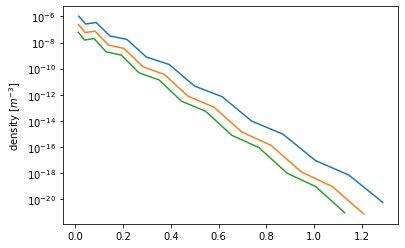

In [12]:
Xn = np.zeros((3, 14))
Xn_sum = fitting_result[4]
T_X_rot_list = fitting_result[0:3]
T_X_vib = fitting_result[3] 
for Xv in np.arange(0, 3):
  for XN in np.arange(1, 15):
    Xn[Xv][XN-1] = Xn_sum * (2*XN+1) * g_as(XN) * math.exp(-E_X_rot(Xv, XN)/kb/T_X_rot_list[Xv]) * math.exp(-E_X_vib(Xv)/kb/T_X_vib)

plt.yscale('log')
plt.ylabel("density [$m^{-3}$]")
for Xv in np.arange(0, 3):
  plt.plot([E_X_rot(Xv, XN) for XN in np.arange(1, 15)], Xn[Xv])